In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import copy
from matplotlib import rc
from IPython import display
import random
%matplotlib inline

from gameofsurvival_libraries import init_grid, grid_to_list, grid_to_set, list_to_grid, set_to_grid
from gameofsurvival_libraries import get_neighbours, apply_rules, fuzzy_rules, calculate_action, time_step
from gameofsurvival_libraries import alive_cells

In [2]:
######################
####  PARAMETERS. ####
######################
epochs = 1000            ### Number of cycles
world_size = 200        ### Linear dimensions of the (squared) world
see_size = 20          ### DO NOT CHANGE. Dimension of the observable world.
                       ### If you change it: you have to change the DRL model input size
group_size = 5         ### DO NOT CHANGE. Linear dimensions of the (suqared) community
                       ### If you change it: you have to change the DRL model output size
filling = 0.05   ### How "full" the starting world is

IsWorldFuzzy = False    ### "Fuzzy" world means that cells have a random chance of switching
p_fuzzy = 1.0/world_size/world_size     ### Note that approx. P(1 switch) = world_size*world_size*p_fuzzy
                       ### If world_size ~ 100, p_fuzzy should be ~ 0.01 ~ to get 100 events (over 10 thousand squares)

alive = 1              ### Def. 1 alive and 0 dead 
dead = 0               ###
start = time.time()

###STARTING WORLD CONFIGURATION###


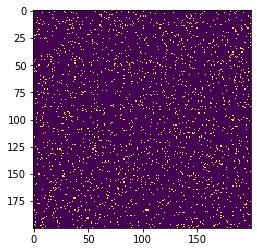

In [3]:
### Generate world and group at random
world = init_grid(world_size)
group = init_grid(group_size)

### PLOT INITIAL STATE
print("###STARTING WORLD CONFIGURATION###")
plt.imshow(world)
plt.show()

In [1]:
### IMPORTING KERAS MODULES!
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')
print(sys.path)
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.datasets import mnist
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

['/Users/simonedicataldo/Desktop/gameofsurvival', '/Users/simonedicataldo/opt/anaconda3/lib/python37.zip', '/Users/simonedicataldo/opt/anaconda3/lib/python3.7', '/Users/simonedicataldo/opt/anaconda3/lib/python3.7/lib-dynload', '', '/Users/simonedicataldo/opt/anaconda3/lib/python3.7/site-packages', '/Users/simonedicataldo/opt/anaconda3/lib/python3.7/site-packages/aeosa', '/Users/simonedicataldo/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/Users/simonedicataldo/.ipython', '/usr/local/lib/python3.7/site-packages']


Using TensorFlow backend.


In [2]:
def model():
    input= Input(shape=(see_size, see_size, 1))
    ## 20x20x1
    x = Conv2D(8, (2, 2), activation='relu', padding='same')(input_img)
    ## 20x20x8
    x = MaxPooling2D((2, 2), padding='same')(x)
    ## 10x10x4
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    ## 10x10x16
    x = MaxPooling2D((2, 2), padding='same')(x)
    ## 5x5x16
    x = Conv2D(25, (2, 2), activation='relu', padding='same')(x)
    ## 5x5x25
    encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)
    ## 4x4x8

NameError: name 'InputLayer' is not defined

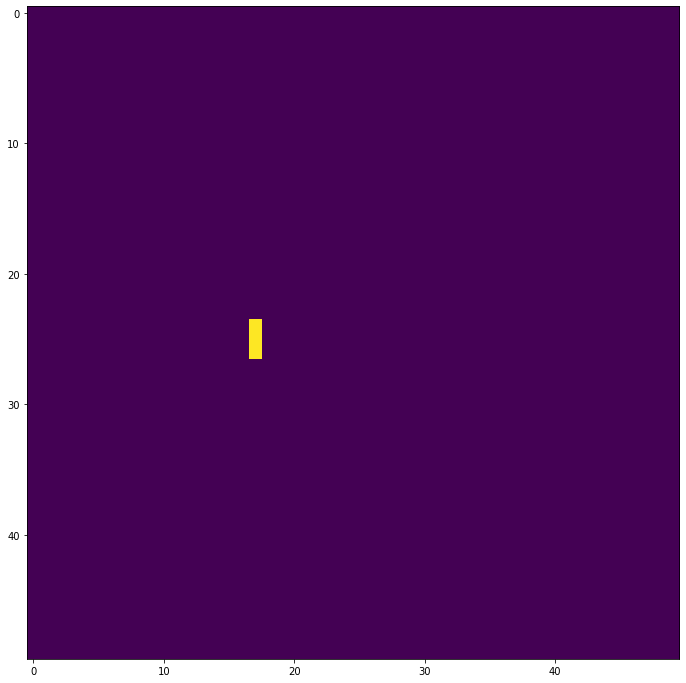

KeyboardInterrupt: 

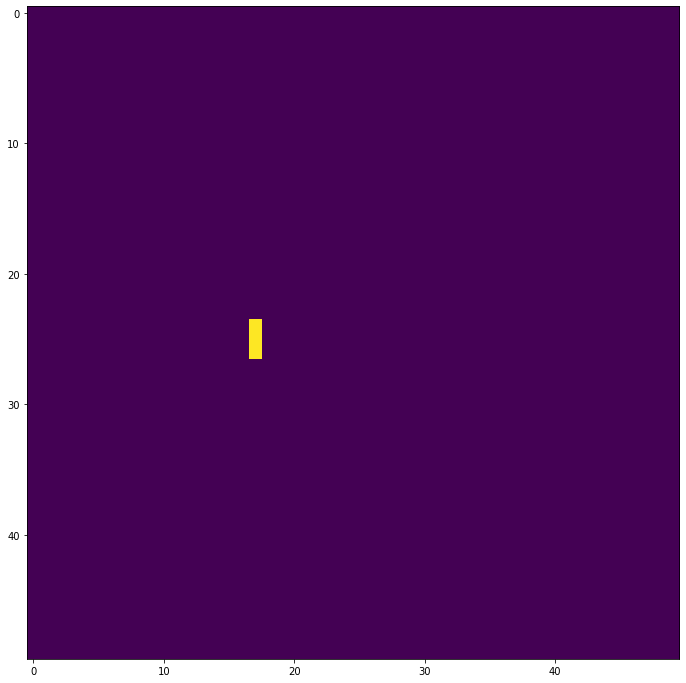

In [4]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(14, 12))
fig.canvas.draw()
img = ax.imshow(world, interpolation='none')
action = np.zeros(group_size*group_size)

## NOW: implement a real choice of action!!

for i in range(epochs):
    ### FIRST STEP: the agent performs an action on the world
    next_world = set_to_grid(alive_cells, world_size)
    next_world = calculate_action(action, next_world)
    alive_cells = grid_to_set(next_world)
    ### SECOND STEP: time evolution (including the action of the agent)
    ### RETURNS: the reward, the status of the world, and the variable "Done"
    reward, world, done = time_step(alive_cells, world_size, IsWorldFuzzy, p_fuzzy)
    ### THIRD STEP: save "old" configuration
    old_world = world
    ### INFORMATIVE MESSAGE
    if (i%(int(epochs/100))==0):
        print(i/epochs*100, "% of epochs done")
    ### PLOT WORLD STATUS
    alive_cells = grid_to_set(world)
    img.set_data(world)
    display.clear_output(wait=True)
    display.display(fig)
    time.sleep(0.1)